In this tutorial, we aim to understand the Radon transform and filtered backprojection algorithm.

## Radon transform 

$$R_f (\theta, r) := \int_{l_{\theta,r}} f(x,y) ds =  \int f(x(s), y(s)) \, ds \quad (*)$$

$$l_{\theta, r} = (x(s), y(s)) =  \{ ( I \cos \theta - s \sin \theta, r \sin \theta + s \cos \theta ) : s \in \mathbb R \} \quad (1)$$

In [2]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt

def radon(img, steps):
    """
    steps: number of angles
    """
    R = np.zeros([steps, len(img)])
    for k in range(steps):
        R[k, :] = np.sum(scipy.misc.imrotate(img, -k * 180./steps, interp='bilinear'), axis=1)
    
    return R

### Generate Radon image from the SheppLogan synthetic image

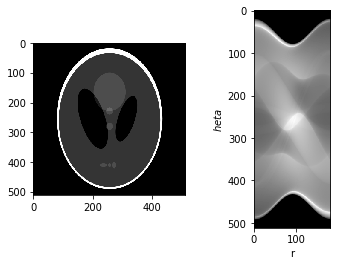

In [3]:
img = np.zeros([100,100])
img[80:81,80:81] = 1.

img = scipy.misc.imread('/Users/jakeoung/work/forward/data/SheppLogan_Phantom.png')
img = img[:,:,0]
# img = scipy.misc.imread('/Users/jakeoung/gdrive/work18/vedrana_ppt/20171219_IACG/OBJECTS/object_1.png')

sinogram = radon(img, 180).transpose()

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap='gray')
ax2.imshow(sinogram, cmap='gray')
plt.xlabel('r')
plt.ylabel('$\theta$')

## Filtered backprojection

$$f ( x ,y ) = \int _ { 0} ^ { \pi } q _ { \phi } ( x \cos \phi + y \sin \phi ) d \phi$$

where

$$\left.\begin{aligned} q _ { \phi } ( \rho ) = \mathcal { F } _ { 1} ^ { - 1} \left[ \mathcal { F } _ { 1} \left[ p _ { \phi } \right] ( \omega ) \cdot | \omega | \right] ( \rho ) \end{aligned} \right.$$

Reference:

https://github.com/scikit-image/scikit-image/blob/master/skimage/transform/radon_transform.py#L127

In [7]:
from scipy.fftpack import fft, ifft, fftfreq

def fbp(sinogram):
    #projection_size_padded = \
        #max(64, int(2 ** np.ceil(np.log2(2 * sinogram.shape[0]))))
    
    output_size = sinogram.shape[0]
    angles = np.linspace(0, 180, sinogram.shape[1], endpoint=False)
    theta = np.pi / 180. * angles
    
    f = fftfreq(sinogram.shape[0]).reshape(-1, 1)   # digital frequency
    omega = 2 * np.pi * f                                # angular frequency
    fourier_filter =2 * np.abs(f)                       # ramp filter
    #fourier_filter = 1
    
    projection = np.fft.fft(sinogram, axis=0) * fourier_filter
    proj_ifft = np.real(np.fft.ifft(projection, axis=0))
    proj_ifft = proj_ifft[:sinogram.shape[0], :]

    
    [X, Y] = np.mgrid[0:output_size, 0:output_size]
    xx = X - int(output_size) // 2
    yy = Y - int(output_size) // 2
    
    res = np.zeros([output_size, output_size])
    
    # interpolation
    for i in range(len(angles)):
#         t = yy * np.cos(theta[i]) - xx * np.sin(theta[i])
        t = xx * np.cos(theta[i]) + yy * np.sin(theta[i])
        x = np.arange(proj_ifft.shape[0]) - sinogram.shape[0] // 2
        
        backprojected = np.interp(t, x, proj_ifft[:, i], left=0, right=0)
        res += backprojected
    
    return res

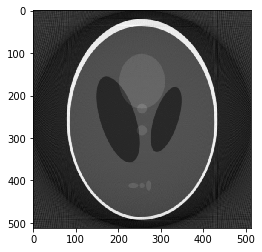

In [8]:
# res = fbp(radon_transform.radon(img, ))
res = fbp(sinogram)
plt.imshow(res)
plt.set_cmap('gray')